# Project3: Fintech company classification problem 

## Step 1) Problem Statement

The goal of the project is to use the data of a fintech company which offers an application in '
free' and 'paid' versions. 

The company wants us to identify those customers who will not enroll in the PAID version of the app so that the greater marketing efforts can go into trying to 'convert' them to paid users.

Since marketing efforts are costly, the company doesn't want to spend resources trying to convert customers who will enroll in the paid version anyway.

## Step 2) Importing the data

In [1]:
#importing necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from dateutil import parser

In [2]:
#the following notebook was run on Google Colaboratory 
#Hence, the following lines of codes are needed (not needed for Anaconda)
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/Udemy ML/Project 3")

Mounted at /content/drive


In [3]:
#importing the csv files
dataset=pd.read_csv('./appdata10.csv')

## Step 3) Exploratory Data Analysis (EDA) & Data Visualization


In [ ]:
#exploring the head of the dataset
dataset.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [ ]:
#description of the numerical fields in the dataset
dataset.describe()


##IMPORTANT OBSERVATIONS:
#10% of the users have played the minigame
#17% of the users have used the premium features
# average age of the user is 31
#16% of the users have liked a feature in the app

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


The data is only for the first 24 hours after a user has installed the application since the free version is only available till then.

### **Description of the data fields**

**first_open**: When the user first opened the app

**screen_list**: Every single screen name the user has used. A list of comma seperated values.

**numscreens**: Number of screens the user has.

**Minigame**: If the user plays the game, the value is 1, else 0.

**Liked**: If the user likes a feature in the app, the value is 1, else 0.

**used_premium_feature**: If the person has never used any premium features available in the free version, the value is 0, else 1.

**enrolled**: If they signed up for the paid version, the value is 1, else 0.

**enrolled_date**: Empty values for the users who didn't enroll for the paid version.





In [ ]:
#cleaning the date and converting it into a numerical field
dataset['hour']=dataset.hour.str.slice(1,3).astype(int)

In [ ]:
#keeping only the numerical fields
dataset2=dataset.copy().drop(columns=['user','screen_list','enrolled_date','first_open','enrolled'])
dataset2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


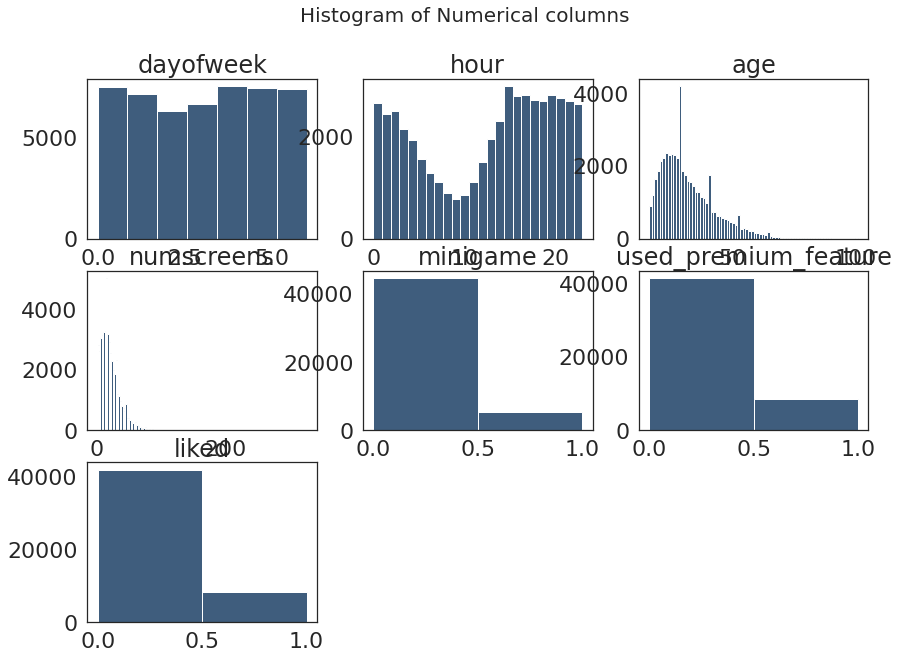

In [ ]:
#Histograms
plt.figure(figsize=(14,10))
plt.suptitle('Histogram of Numerical columns', fontsize=20)
for i in range(1, dataset2.shape[1]+1): #since python doesn't include the last element in a range
  plt.subplot(3,3,i)
  f=plt.gca()
  f.set_title(dataset2.columns.values[i-1])

  vals= np.size(dataset2.iloc[:,i-1].unique()) #to determine the number of the bins for each field

  plt.hist(dataset2.iloc[:,i-1], bins=vals, color='#3F5D7D') #color determined manually

plt.show()

### Observations from the histogram

The hour has a big drop which can be because that particular time (when the drop is observed) may be early hours in PST/EST.

There are tiny peaks observed in the age histogram around the ages of 29/30, 41/42, 51 etc.

Most people have not liked or used the mini game.


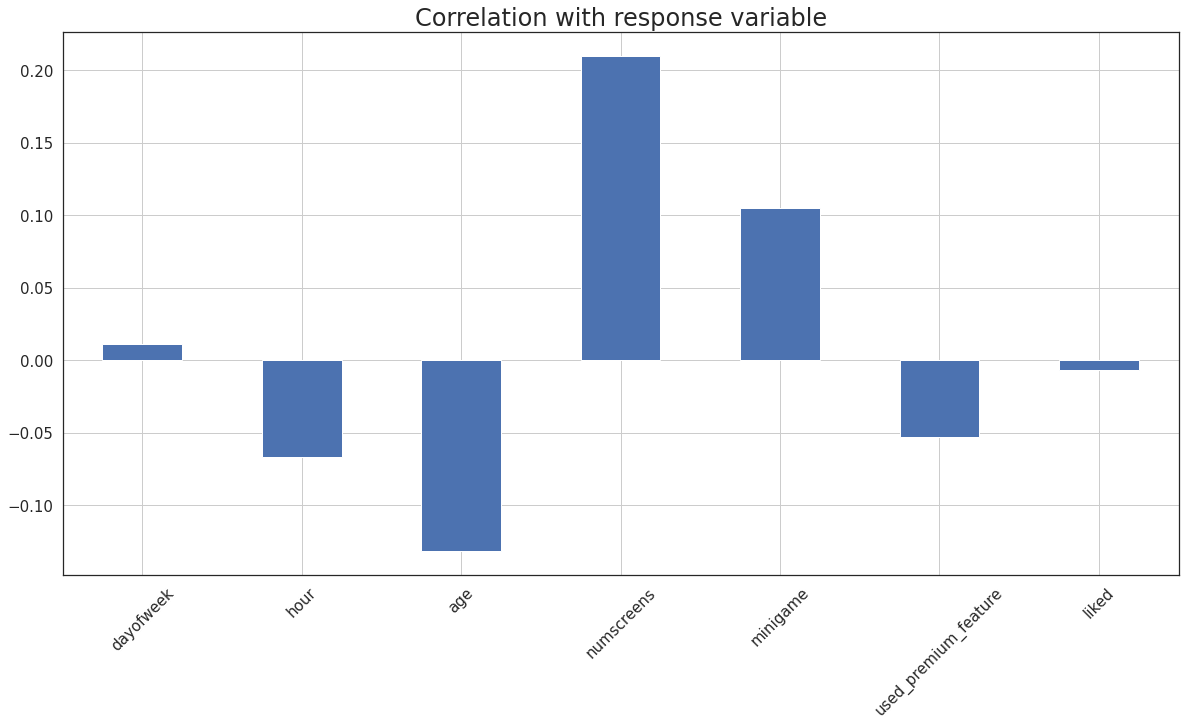

In [ ]:
#Correlation with response
dataset2.corrwith(dataset['enrolled']).plot.bar(figsize=(20,10),
                                                title='Correlation with response variable',
                                                fontsize=15,
                                                rot=45, #x-axis labels are rotated by 45 degrees)
                                                grid=True)

### Observations from the bar chart

The more a user uses the premium features, lesser are the chances that a user goes for the paid version

'age' is negatively correlated to the response variable

'numscreesns' and 'dayofweek' seem to have positive correlations

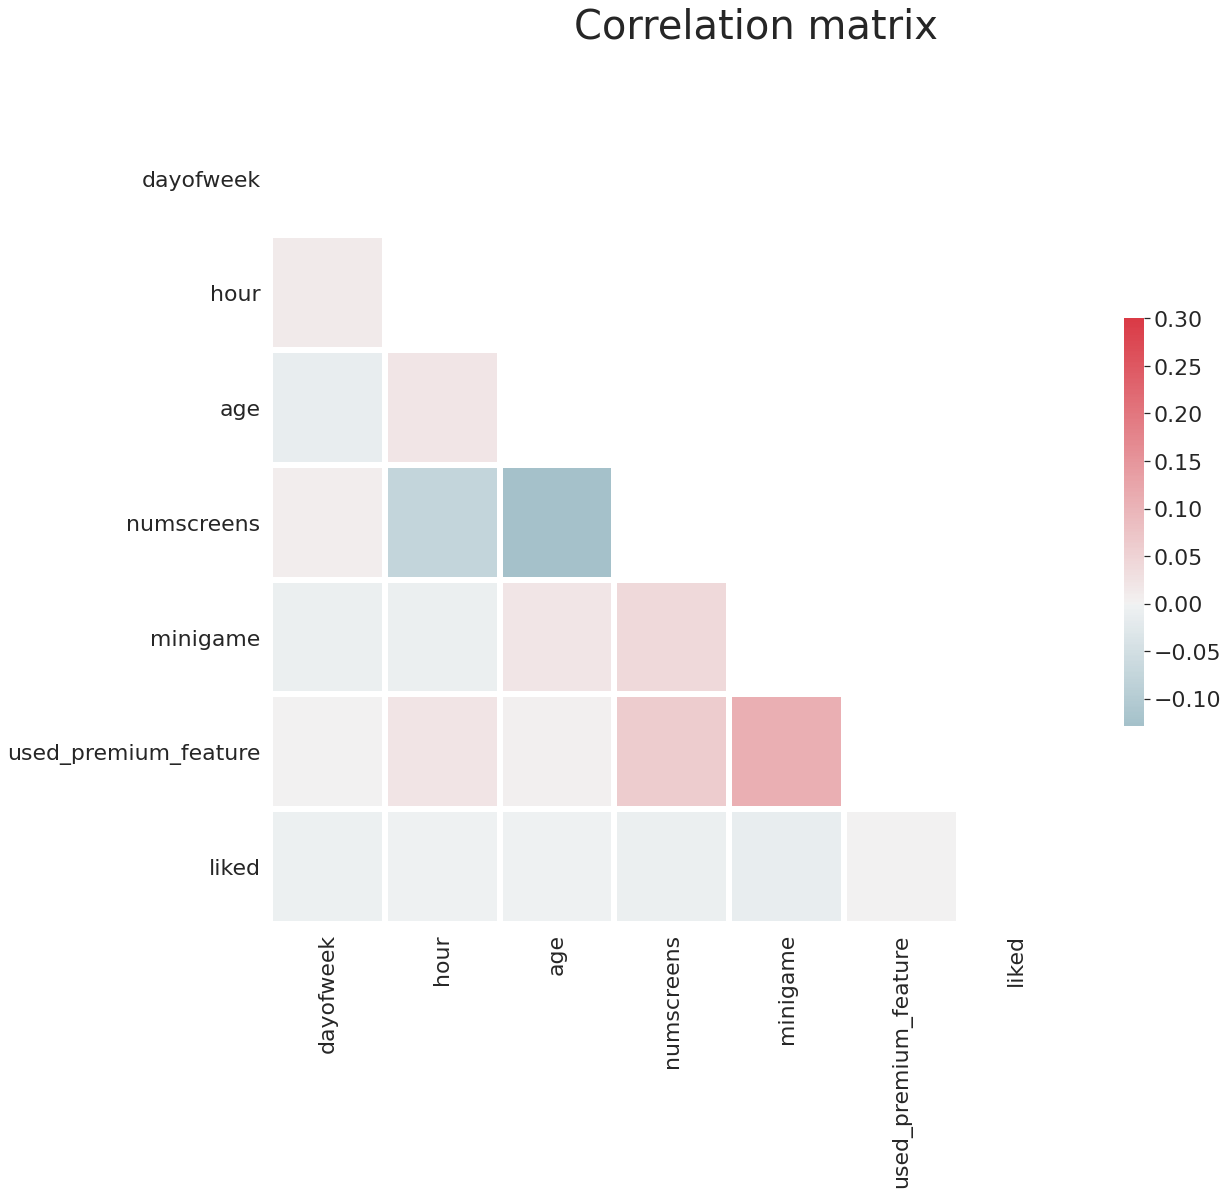

In [ ]:
#Correlation matrix
#background
sns.set(style='white', font_scale=2)

#compute the correlation matrix
#creating an array for the correlation matrix 
corr=dataset2.corr()

#generate a mask for the upper traingle
#shape of the matrix is a triangle
mask=np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

#set up the matplotlib figure
f,ax= plt.subplots(figsize=(18,15))
f.suptitle('Correlation matrix', fontsize=40)

#generate a colormap
cmap=sns.diverging_palette(220,10,as_cmap=True)

#draw the heatmap with the mask and correct aspect ratio
sns.heatmap (corr, mask=mask, cmap=cmap, vmax=.3,
             center=0, square=True, linewidth=5,
             cbar_kws={'shrink': .5})



### Observations from the correlation matrix

'dayofweek' is not strongly correlated to any field


'age' is negatively correlated to 'numscreens': older people have lesser screens

'numscreens' & 'minigame' is positively correlated to 'used_premium_feature'

## Step 4) Feature Engineering

In [ ]:
#convert everything into a date-time object
dataset['first_open']=[parser.parse(row_data) for row_data in dataset.first_open]

In [ ]:
#since some values are null, we add 'if isinstance'
#otherwise the code will give an error
dataset['enrolled_date']=[parser.parse(row_data) if isinstance(row_data, str) else row_data for row_data in dataset.enrolled_date]

In [ ]:
#calculating the difference between these 2 columns
#timedelta64[h]- to get the time difference in hours
dataset['difference']=(dataset['enrolled_date']-dataset['first_open']).astype('timedelta64[h]') #convert it to hours

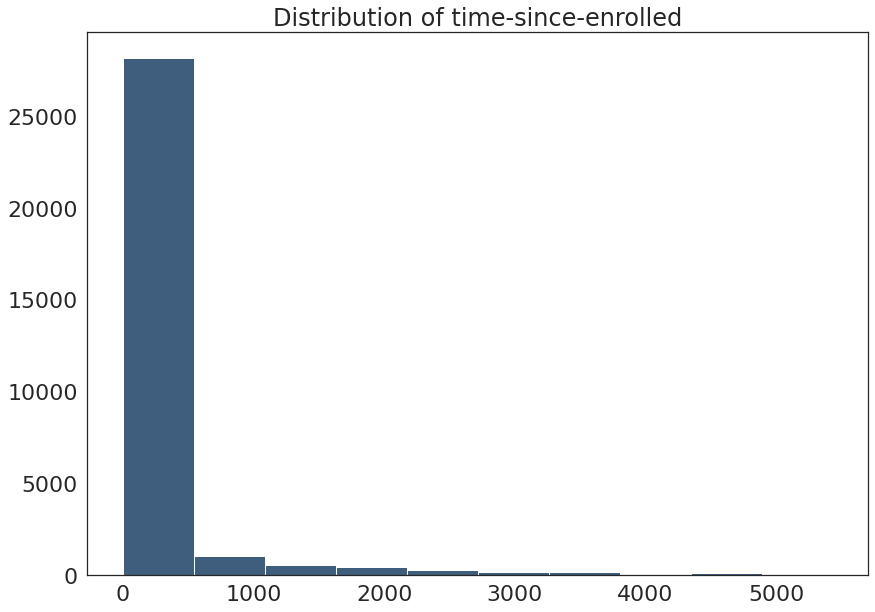

In [ ]:
plt.figure(figsize=(14,10))
plt.hist(dataset.difference.dropna(),color='#3F5D7D')
plt.title('Distribution of time-since-enrolled')
plt.show()

#Does the conversion from free to paid happen in the first 100 hours or first 500 hours?
#further scrutiny of the histogram since the distribution is right skewed.

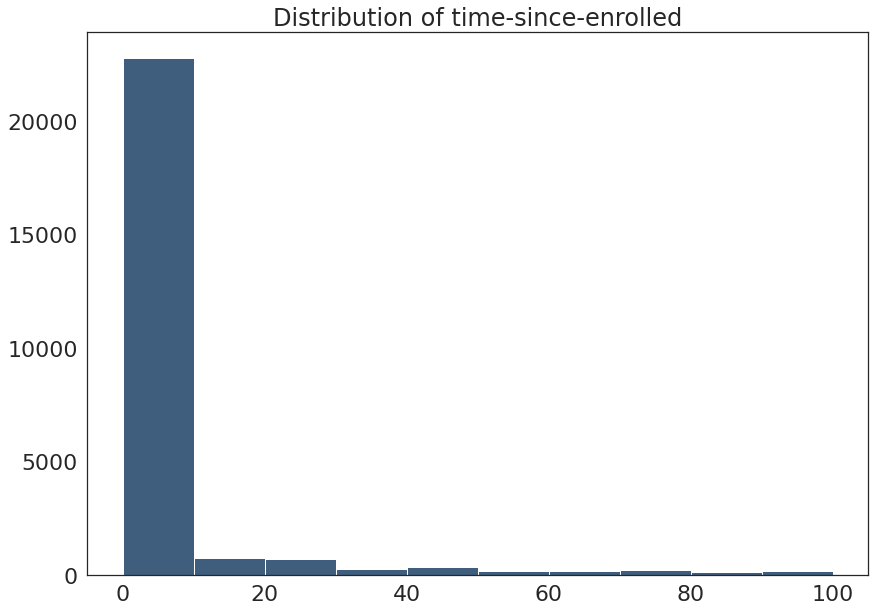

In [ ]:
plt.figure(figsize=(14,10))
plt.hist(dataset.difference.dropna(),color='#3F5D7D', range=[0,100])
plt.title('Distribution of time-since-enrolled')
plt.show()

#the majority of the distribution happen in the first 10 hours.

In [ ]:
#the cutoff is decided at 48 hours (2 days) for the response variable
#the people who have not enrolled and have a time difference greater than 48 will automatically be considered as not enrolled in the paid version
#this is necessary to test the model
#having a cut-off of 2 days means we have to wait 2 days before testing the model and seeing if it predicted correctly.

dataset.loc[dataset.difference>48,'enrolled']=0
dataset=dataset.drop(columns=['difference','first_open','enrolled_date'])

### Formatting the top screen list

In [ ]:
# contains information about the top screens visited by the people
top_screens=pd.read_csv('./top_screens.csv').top_screens.values

In [ ]:
top_screens

array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

In [ ]:
dataset.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked
0,235136,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,0
1,333588,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0
2,254414,1,19,23,"Splash,Cycle,Loan,",3,0,1,0,1
3,234192,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,0
4,51549,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,1


In [ ]:
#next few lines of code is to convert each screen into its own column.

#currently number of features = number of commas+1.
#this will make the number of ',' equal to the number of screens present in the rows
#this is essential because we will count the number of commas at the end to determine the total number of other features

dataset['screen_list']=dataset.screen_list.astype(str) + ','

In [ ]:
for sc in top_screens:
  #create a column for each screen name-return a boolean and then it is converted into an integer
  dataset[sc]=dataset.screen_list.str.contains(sc).astype(int)
  #remove that screen from the screen list
  dataset['screen_list']=dataset.screen_list.str.replace(sc+',','')


In [ ]:
dataset['Other']=dataset.screen_list.str.count(',')
dataset=dataset.drop(columns=['screen_list'])

In [ ]:
dataset.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,Loan2,location,Institutions,Credit3Container,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Credit3Dashboard,Loan3,CC1Category,Splash,Loan,CC1,RewardsContainer,Credit3,Credit1,EditProfile,Credit2,Finances,CC3,Saving9,Saving1,Alerts,Saving8,Saving10,Leaderboard,Saving4,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,Saving7,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,Saving2,Saving6,Saving2Amount,Saving5,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,Other
0,235136,3,2,23,15,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7
1,333588,6,1,24,13,0,0,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
2,254414,1,19,23,3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,234192,4,16,28,40,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
4,51549,1,18,31,32,0,0,1,1,1,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10


In [ ]:
# Funnels- group of screens belonging to the same set.
#Since there are numerous savings screens, we will aggregate them together
#need to remove them since the columns are correlated and will create problems in model

savings_screens=['Saving1',
                 'Saving2',
                 'Saving2Amount',
                 'Saving4',
                 'Saving5',
                 'Saving6',
                 'Saving7',
                 'Saving8',
                 'Saving9',
                 'Saving10']

In [ ]:
dataset['SavingsCount']=dataset[savings_screens].sum(axis=1)

In [ ]:
dataset=dataset.drop(columns=savings_screens)

In [ ]:
#similar process for multiple funnels:-
#credit monitory screens, credit card screens and loan screens

cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

In [ ]:
dataset.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,Institutions,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Splash,RewardsContainer,EditProfile,Finances,Alerts,Leaderboard,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingsCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,15,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,2,0,1


In [ ]:
#saving the results to a new dataset
dataset.to_csv('new_appdata10.csv', index = False)

## Step 5) Data Preprocessing for the Model Building

In [ ]:
dataset=pd.read_csv('./new_appdata10.csv')

In [ ]:
#splitting the data
response=dataset['enrolled'] #dependent variable (y)
dataset=dataset.drop(columns=['enrolled']) #independent variable (X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(dataset,
                                                  response,
                                                  test_size=0.2,
                                                  random_state=0)

In [ ]:
#train_identifier= user identifier for the training set 
#needed at the end but not in the model hence removed and kept away

train_identifier= X_train['user']
X_train=X_train.drop(columns=['user'])

test_identifier=X_test['user']
X_test=X_test.drop(columns=['user'])

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_x= StandardScaler()

#StandardScaler returns a numpy array. 
#it loses the column names and the index. We need the index and column names for the model.
#hence we need to save it in a new variable X_train2

X_train2=pd.DataFrame(sc_x.fit_transform(X_train))

#we only transform because its already fit on the training dataset
X_test2=pd.DataFrame(sc_x.transform(X_test))

In [ ]:
#to get column names for the scaled dataset
X_train2.columns=X_train.columns.values
X_test2.columns=X_test.columns.values

In [ ]:
#to get index for the scaled dataset
X_train2.index=X_train.index.values
X_test2.index=X_test.index.values

In [ ]:
#convert the orignal training and test set into the scaled dataset

X_train=X_train2
X_test=X_test2

#the training dataset is not scaled, i.e., all the numerical features are normalized
# we need to do this so that no numerical field have a larger influence on the model simply because it has large absolute values

## Step 6) Model Building

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#L2 (Ridge) regularization model
# there may be other correlations that exist so L2 will penalize any variable which is strongly correlated to response variable.

classifier = LogisticRegression(random_state = 0, penalty='l2')
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#predicting the results
y_pred=classifier.predict(X_test)

In [ ]:
y_pred

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
#evaluating the result
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print(f'The accuracy is',accuracy_score(y_test, y_pred))
print(f'The precision is', precision_score(y_test, y_pred)) 
print(f'The recall is',recall_score(y_test, y_pred)) 
print(f'the F1 score is',f1_score(y_test, y_pred))

The accuracy is 0.768
The precision is 0.7617422721798475
The recall is 0.7700892857142857
the F1 score is 0.7658930373360243


Test Data Accuracy: 0.7680


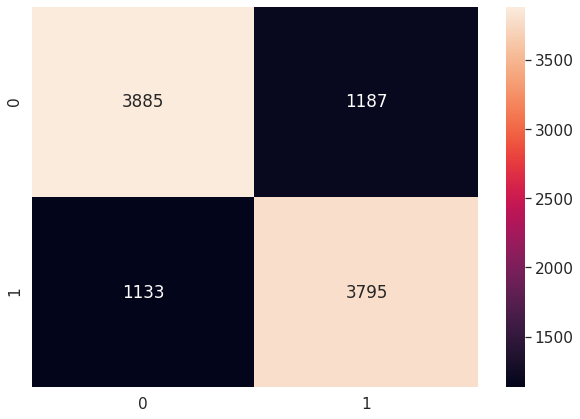

In [ ]:
#plotting the confusion matrix
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [ ]:
# Applying k-Fold Cross Validation
# to ensure that the model runs effectively on different subsets of data and is not overfitting
# end result is the avg accuracy

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Logistic Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

Logistic Accuracy: 0.767 (+/- 0.009)


## Formatting the final results

In [ ]:
# Analyzing Coefficients
#reset_index(drop=True) implies do not return an index

final_results = pd.concat([y_test, test_identifier], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [ ]:
#exploring what the final results look like
final_results.head()

,user,enrolled,predicted_reach
0,239786,1,1
1,279644,1,1
2,98290,0,0
3,170150,1,1
4,237568,1,1


## Step 7) Conclusion

The final model had a 76% accuracy.

Having this model, now we can narrow our marketing efforts to who will subscribe and save money for the company.

User likely to subscribe naturally will not be targeted and those who might leave will be given an offer they can't refuse.


